In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix

import torch
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import ToTensor

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

In [3]:
data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [30]:
n_points = 3000
d_latent = 2

x, label = np.zeros((n_points, 784)), np.zeros(n_points, dtype=int)
for i in range(n_points):
    xx, ll = data[i]
    x[i], label[i] = xx.numpy().flatten(), ll

In [31]:
def visualize(z_pred, method):
#     fig = plt.figure()
#     ax = fig.add_subplot(projection='3d')
    for i in range(10):
        idx = label == i
        plt.plot(z_pred[idx, 0], z_pred[idx, 1], '.', label=f'{i}')
    plt.legend()
    plt.title(f'{method}')

0.504

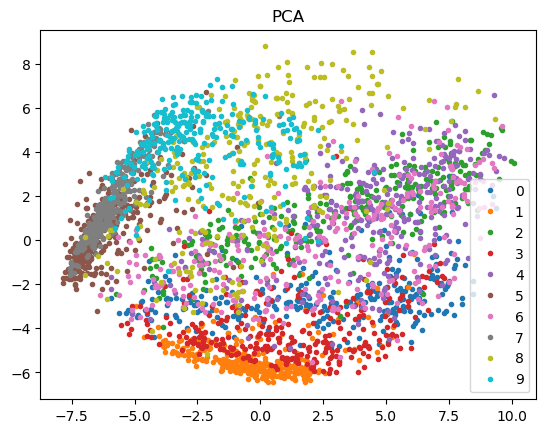

In [32]:
z_pca = PCA(n_components=d_latent).fit_transform(x)
visualize(z_pca, 'PCA')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_pca, label, cv=5)
scores.mean()

0.5536666666666668

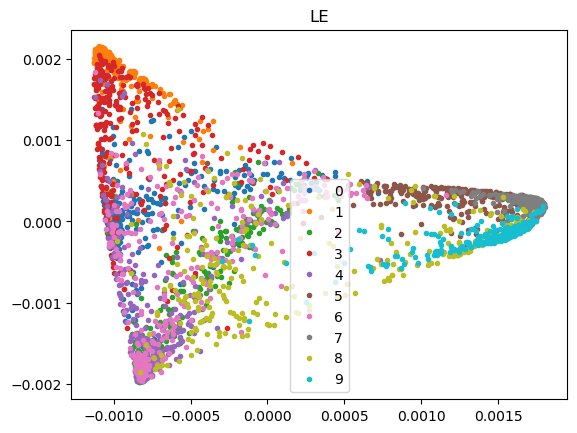

In [33]:
z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x)
visualize(z_le, 'LE')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_le, label, cv=5)
scores.mean()

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


0.7729999999999999

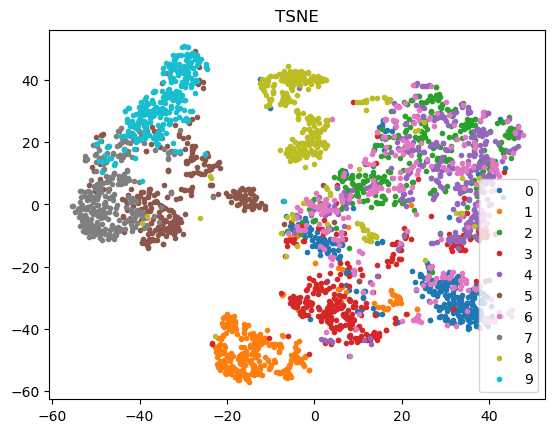

In [34]:
z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x)
visualize(z_tsne, 'TSNE')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_tsne, label, cv=5)
scores.mean()

0.5509999999999999

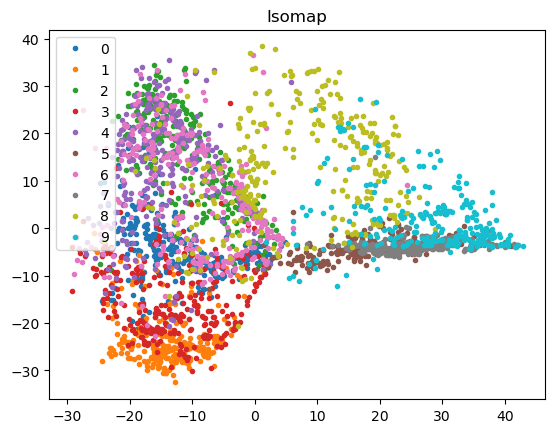

In [35]:
z_isomap = Isomap(n_components=d_latent).fit_transform(x)
visualize(z_isomap, 'Isomap')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_isomap, label, cv=5)
scores.mean()

0.743

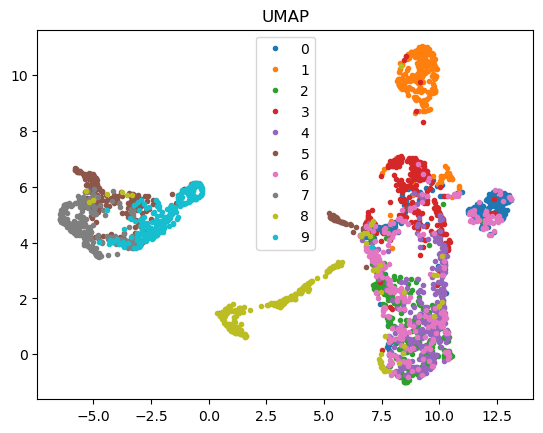

In [36]:
z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x)
visualize(z_umap, 'UMAP')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_umap, label, cv=5)
scores.mean()

Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.6, number of cliques: 1963


0.6635

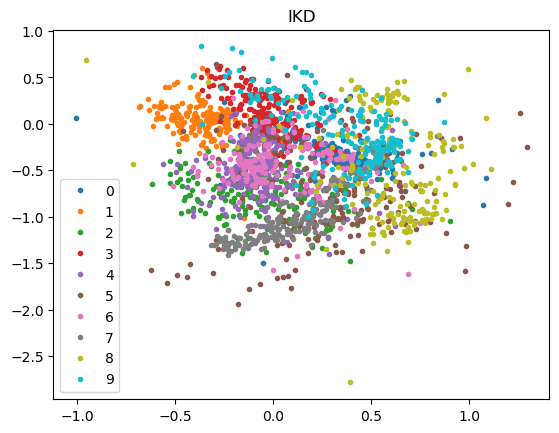

In [19]:
z_ikd = core.ikd_blockwise(x, d_latent=d_latent, clique_th=0.6, max_n_cliques=2)
visualize(z_ikd, 'IKD')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, label, cv=5)
scores.mean()

0.6513333333333333

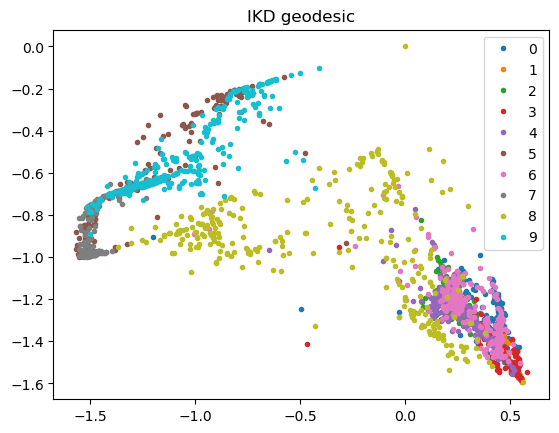

In [41]:
corr_samp = np.corrcoef(x)
corr_samp_th = corr_samp.copy()
corr_samp_th[corr_samp_th <= 1e-3] = 1e-3

a = -np.log(corr_samp_th)
a_new = np.zeros((n_points, n_points))
np.fill_diagonal(a, 1e5)
for i in range(n_points):
    idx = np.argpartition(a[i], 5)[:5]
    a_new[i, idx] = a[i, idx]
    a_new[idx, i] = a[idx, i]
d = shortest_path(csr_matrix(a_new), directed=False)
corr_geodesic = np.exp(-d)

z_ikd = core.ikd(corr_geodesic, d_latent)
visualize(z_ikd, 'IKD geodesic')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, label, cv=5)
scores.mean()